In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy


---
# VIDEO: Mean-smooth a time series
---


In [6]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time) # 3000
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noise_amplitude = 5

3000


#### np.interp(x, xp, fp, left=None, right=None, period=None)
It takes three primary arguments:

x: This is the 'x-coordinates' of the points at which to interpolate.
xp: The 'x-coordinates' of the data points.
fp: The 'y-coordinates' of the data points.

In [15]:
# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noise_amplitude * np.random.randn(n)
signal = ampl + noise  # add some noise to original signal

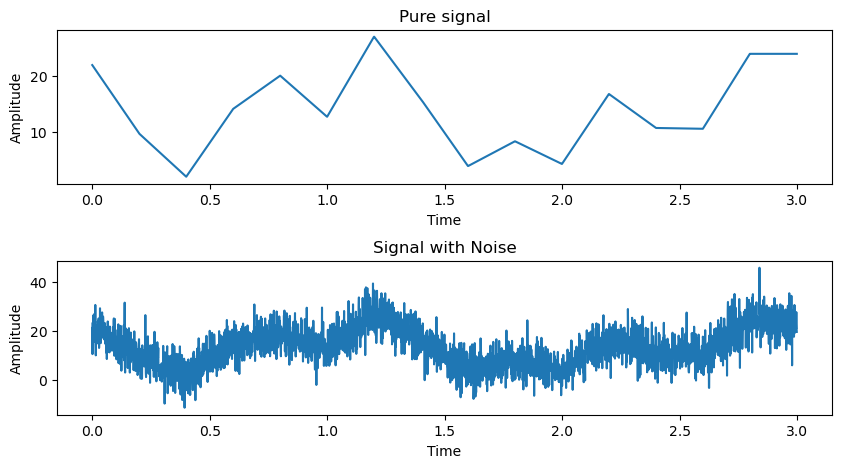

In [22]:
plt.figure(figsize = (10, 5))
# subplot two graphs
plt.subplot(211)
plt.plot(time, ampl)
plt.title("Pure signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(212)
plt.plot(time, signal)
plt.title("Signal with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# add gap between two graphs
plt.subplots_adjust(hspace = 0.5)
plt.show()

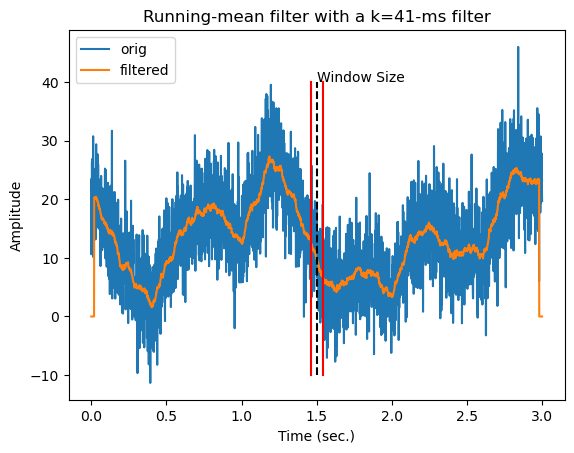

In [36]:
# initialize filtered signal vector

filtsig = signal.copy() # if we want the initial signal to be the signal
filtsig = np.zeros(n) # if we want the initial signal to be 0

# implement the running mean filter
k = 20 # filter window is actually k*2+1
for i in range(k,n-k): # k = 15, n = 3000
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k+1])

# compute window size in ms
windowsize = 1000*(k*2+1) / srate


# plot the noisy and filtered signals
plt.plot(time,signal,label='orig')
plt.plot(time,filtsig,label='filtered')

# add a vertical line in the plot at x = 1.5
plt.plot([1.5,1.5],[-10,40],'k--')
plt.plot([1.5-windowsize/1000,1.5-windowsize/1000],[-10,40],'r')
plt.plot([1.5+windowsize/1000,1.5+windowsize/1000],[-10,40],'r')

plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)
# add annotation to the plot
plt.annotate('Window Size', xy=(1.5, 40), xytext=(1.5, 40))
plt.show()



---
# VIDEO: Gaussian-smooth a time series
---

### we use the same signal as above

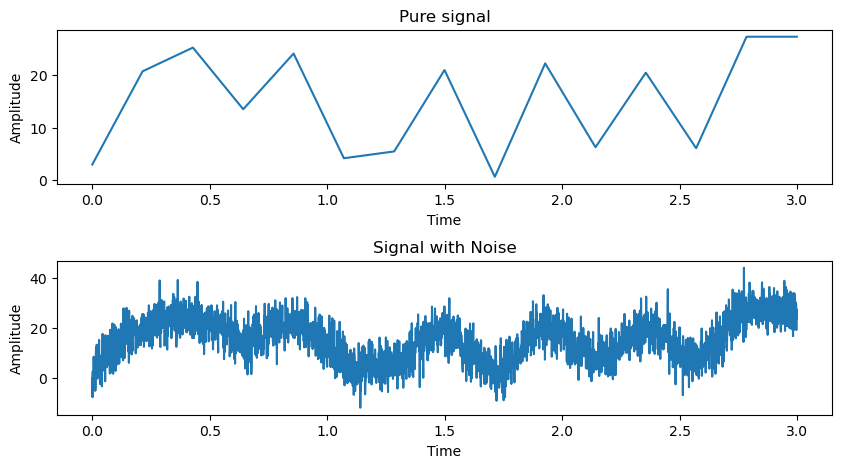

In [37]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(1,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise

plt.figure(figsize = (10, 5))
# subplot two graphs
plt.subplot(211)
plt.plot(time, ampl)
plt.title("Pure signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(212)
plt.plot(time, signal)
plt.title("Signal with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# add gap between two graphs
plt.subplots_adjust(hspace = 0.5)
plt.show()

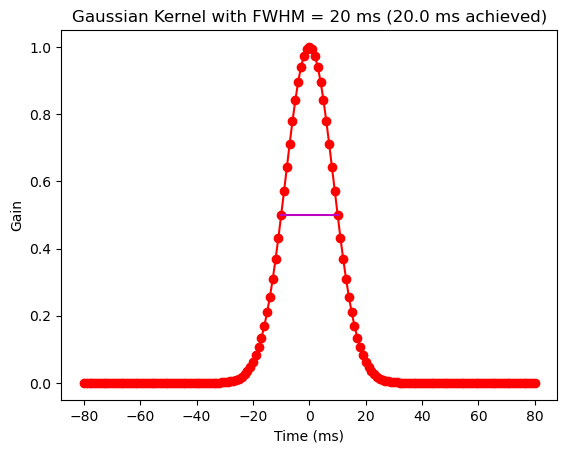

In [83]:
## create Gaussian kernel
# full-width half-maximum
fwhm = 20 # in ms

# normalized time vector in ms
# k cannot be so small that the Gaussian is not zero at the ends
# k cannot be so large that the Gaussian is zero at most of the time points because of the edge
# effects
k = 80
gtime = 1000 * np.arange(-k, k + 1) / srate # [-100, 100]

# create Gaussian window
gauswin = np.exp(-(4 * np.log(2) * gtime ** 2) / fwhm ** 2) # y in [-100, 100] ms

# compute empirical FWHM (Practical FWHM)
pstPeakHalf = k + np.argmin((gauswin[k:] - .5) ** 2) # 113 = 100 + 13
prePeakHalf = np.argmin((gauswin - .5) ** 2) # 87

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]  # 26

# show the Gaussian
plt.plot(gtime, gauswin, 'ro-')
plt.plot([gtime[prePeakHalf], gtime[pstPeakHalf]], [gauswin[prePeakHalf], gauswin[pstPeakHalf]],
         'm')
# then normalize Gaussian to unit energy
# without this, the filtered signal will be scaled up (larger than the noise signal)
gauswin = gauswin / np.sum(gauswin)

plt.xlabel('Time (ms)')
plt.ylabel('Gain')
plt.title("Gaussian Kernel with FWHM = " + str(fwhm) + " ms (" + str(empFWHM) + " ms achieved)")

plt.show()

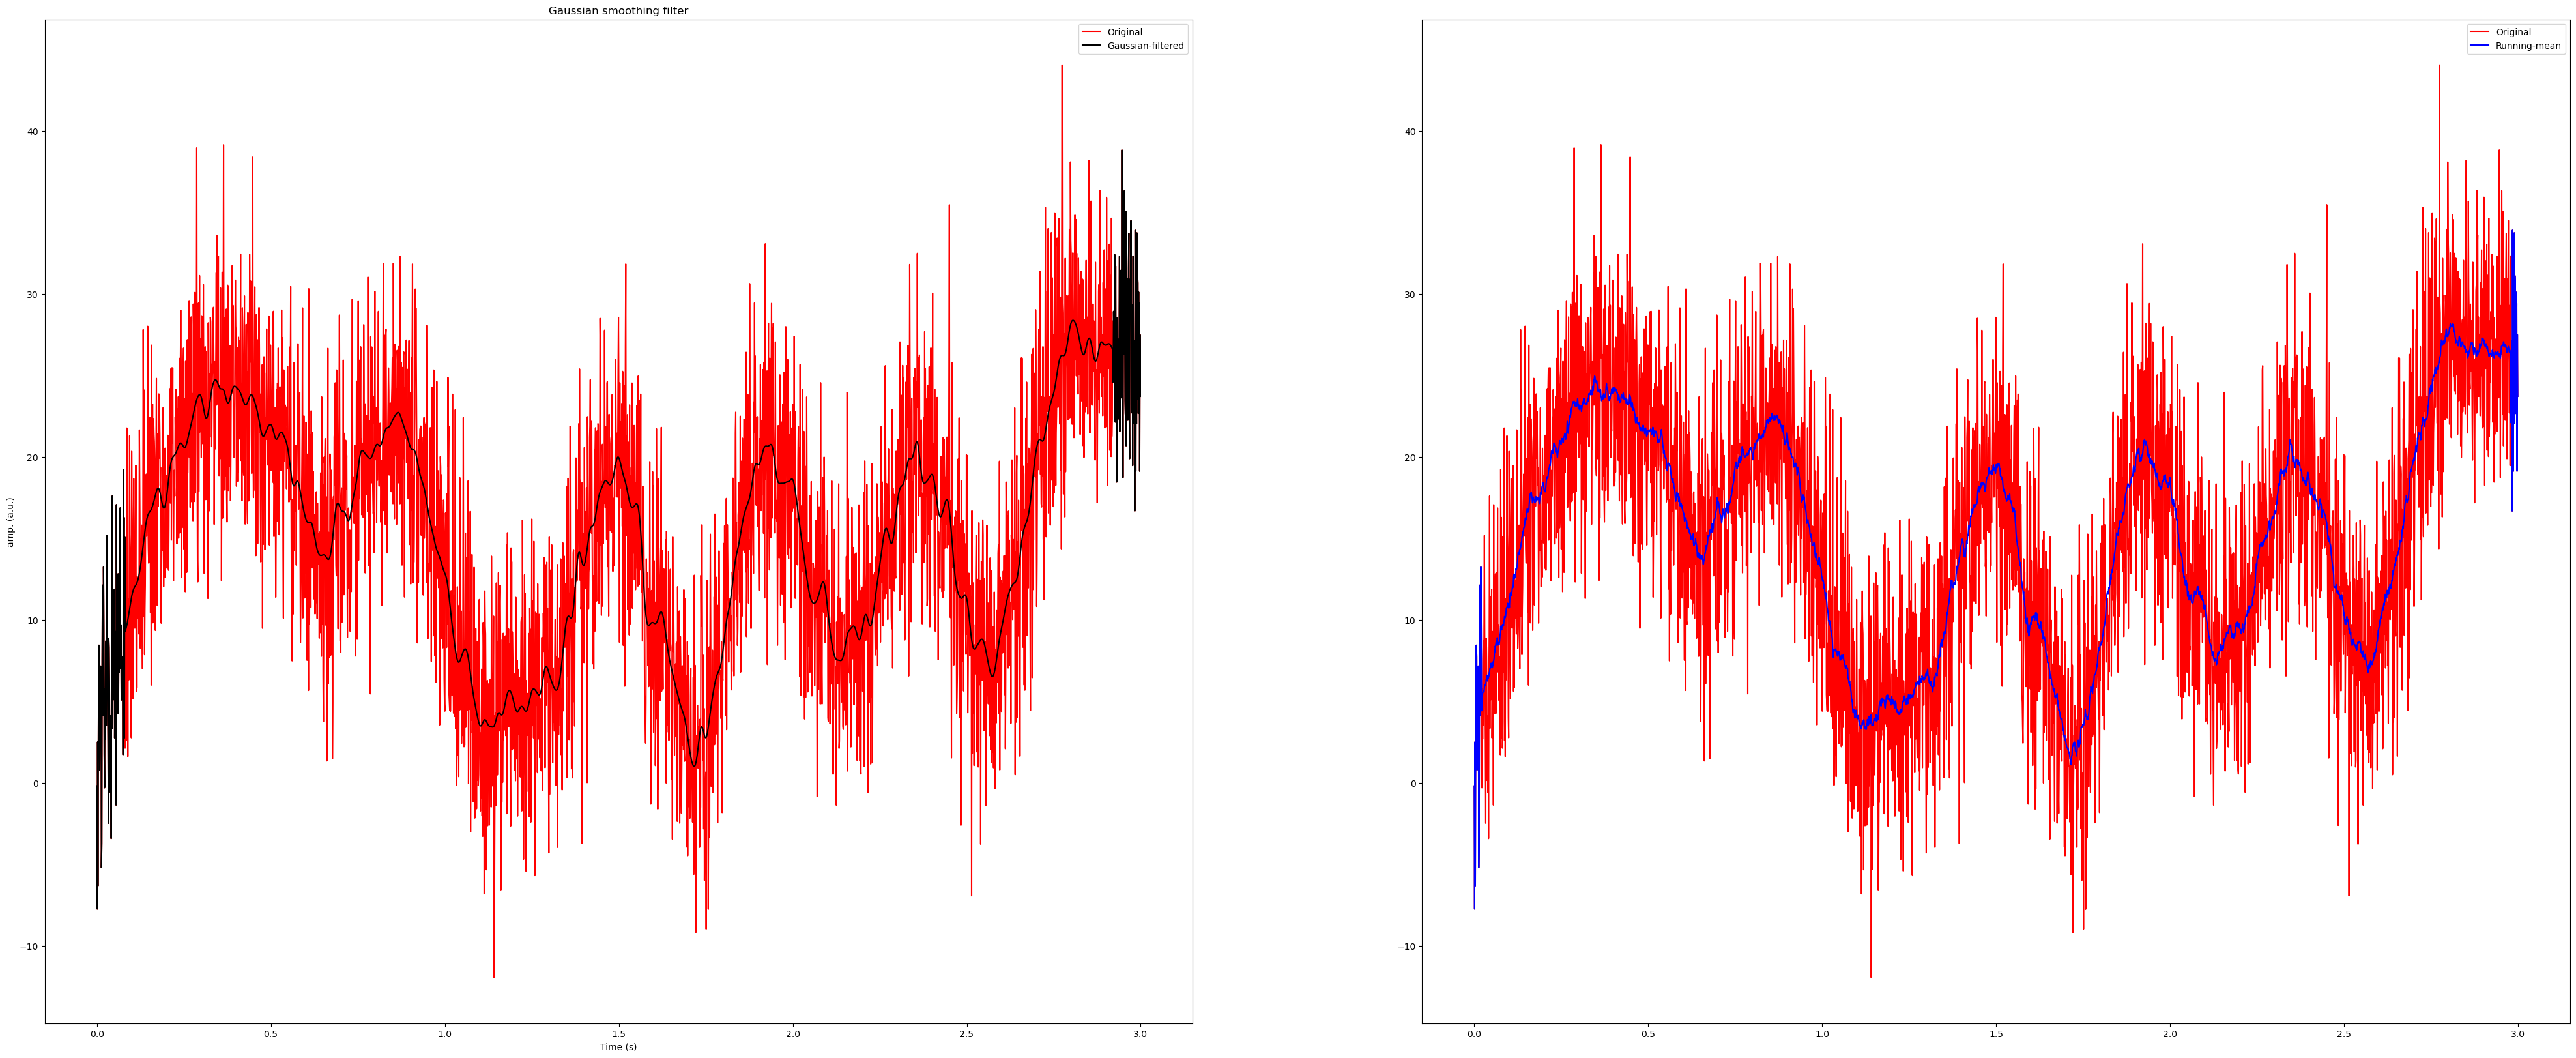

In [84]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal)

# # implement the running mean filter
for i in range(k + 1, n - k):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum(signal[i - k:i + k + 1] * gauswin)

# plot
plt.figure(figsize = (50, 20))
plt.subplot(121)
plt.plot(time, signal, 'r', label = 'Original')
plt.plot(time, filtsigG, 'k', label = 'Gaussian-filtered')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

## for comparison, plot mean smoothing filter

# initialize filtered signal vector
filtsigMean = copy.deepcopy(signal)

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 20  # filter window is actually mk*2+1
for i in range(mk + 1, n - mk - 1):
    # each point is the average of k surrounding points
    filtsigMean[i] = np.mean(signal[i - mk:i + mk + 1])

plt.subplot(122)
plt.plot(time, signal, 'r', label = "Original")
plt.plot(time, filtsigMean, 'b', label = 'Running-mean')

plt.legend()
plt.show()


---
# VIDEO: Gaussian-smooth a spike time series
---


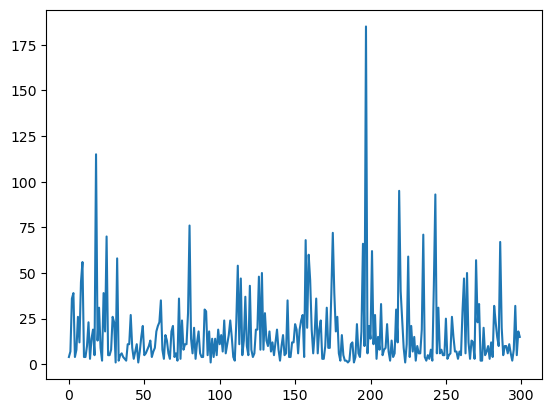

In [89]:
## generate time series of random spikes

# number of spikes
n = 300

# inter-spike intervals (ISI) (exponential distribution for bursts)
isi = np.round(np.exp(np.random.randn(n)) * 10)  # [300, ]

plt.plot(isi)
plt.show()

(5133,)


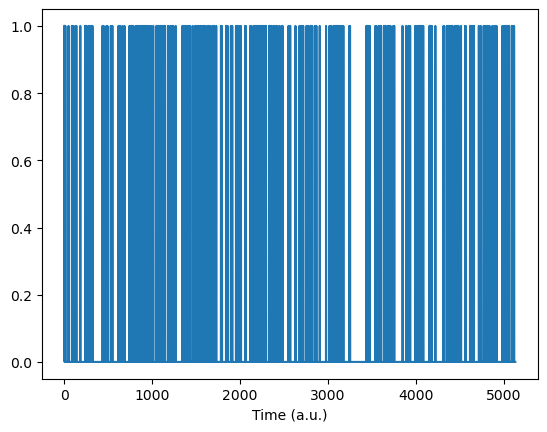

In [91]:
# generate spike time series
spikets = np.zeros(int(sum(isi)))

for i in range(0,n):
    spikets[ int(np.sum(isi[0:i])) ] = 1

print(spikets.shape)

# plot
plt.plot(spikets)
plt.xlabel('Time (a.u.)')
plt.show()

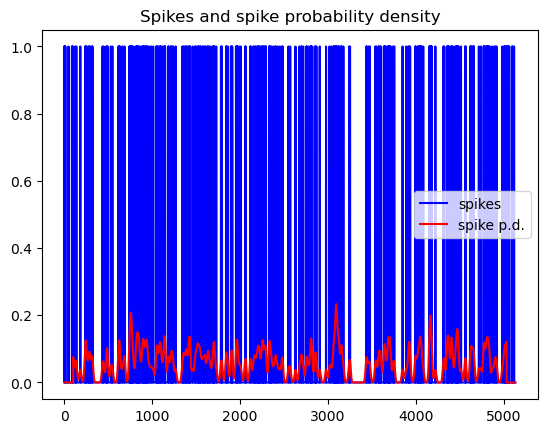

In [92]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in points

# normalized time vector in indices
k = 100;
gtime = np.arange(-k,k+1)

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the Gaussian Smoothing Filter
for i in range(k+1,len(spikets)-k):
    filtsigG[i] = np.sum( spikets[i-k:i+k+1]*gauswin )

# plot the filtered signal (spike probability density)
plt.plot(spikets,'b',label='spikes')
plt.plot(filtsigG,'r',label='spike p.d.')
plt.legend()
plt.title('Spikes and spike probability density')
plt.show()


---
# VIDEO: Denoising via TKEO
---


In [95]:
import pandas as pd
# import data
emgdata = sio.loadmat('emg4TKEO.mat')


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Aug 19 21:13:54 2018', '__version__': '1.0', '__globals__': [], 'emg': array([[59.18904 , 57.842308, 57.46825 , ..., 56.037285, 56.66291 ,
        53.86403 ]], dtype=float32), 'emgtime': array([[-1000.      ,  -998.046875,  -996.09375 , ...,  1496.09375 ,
         1498.046875,  1500.      ]]), 'fs': array([[512]], dtype=uint16)}


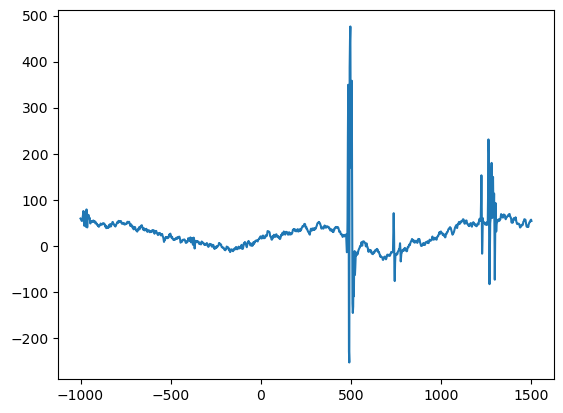

In [96]:
# extract needed variables
emgtime = emgdata['emgtime'][0]
emg  = emgdata['emg'][0]

plt.plot(emgtime, emg)
plt.show()

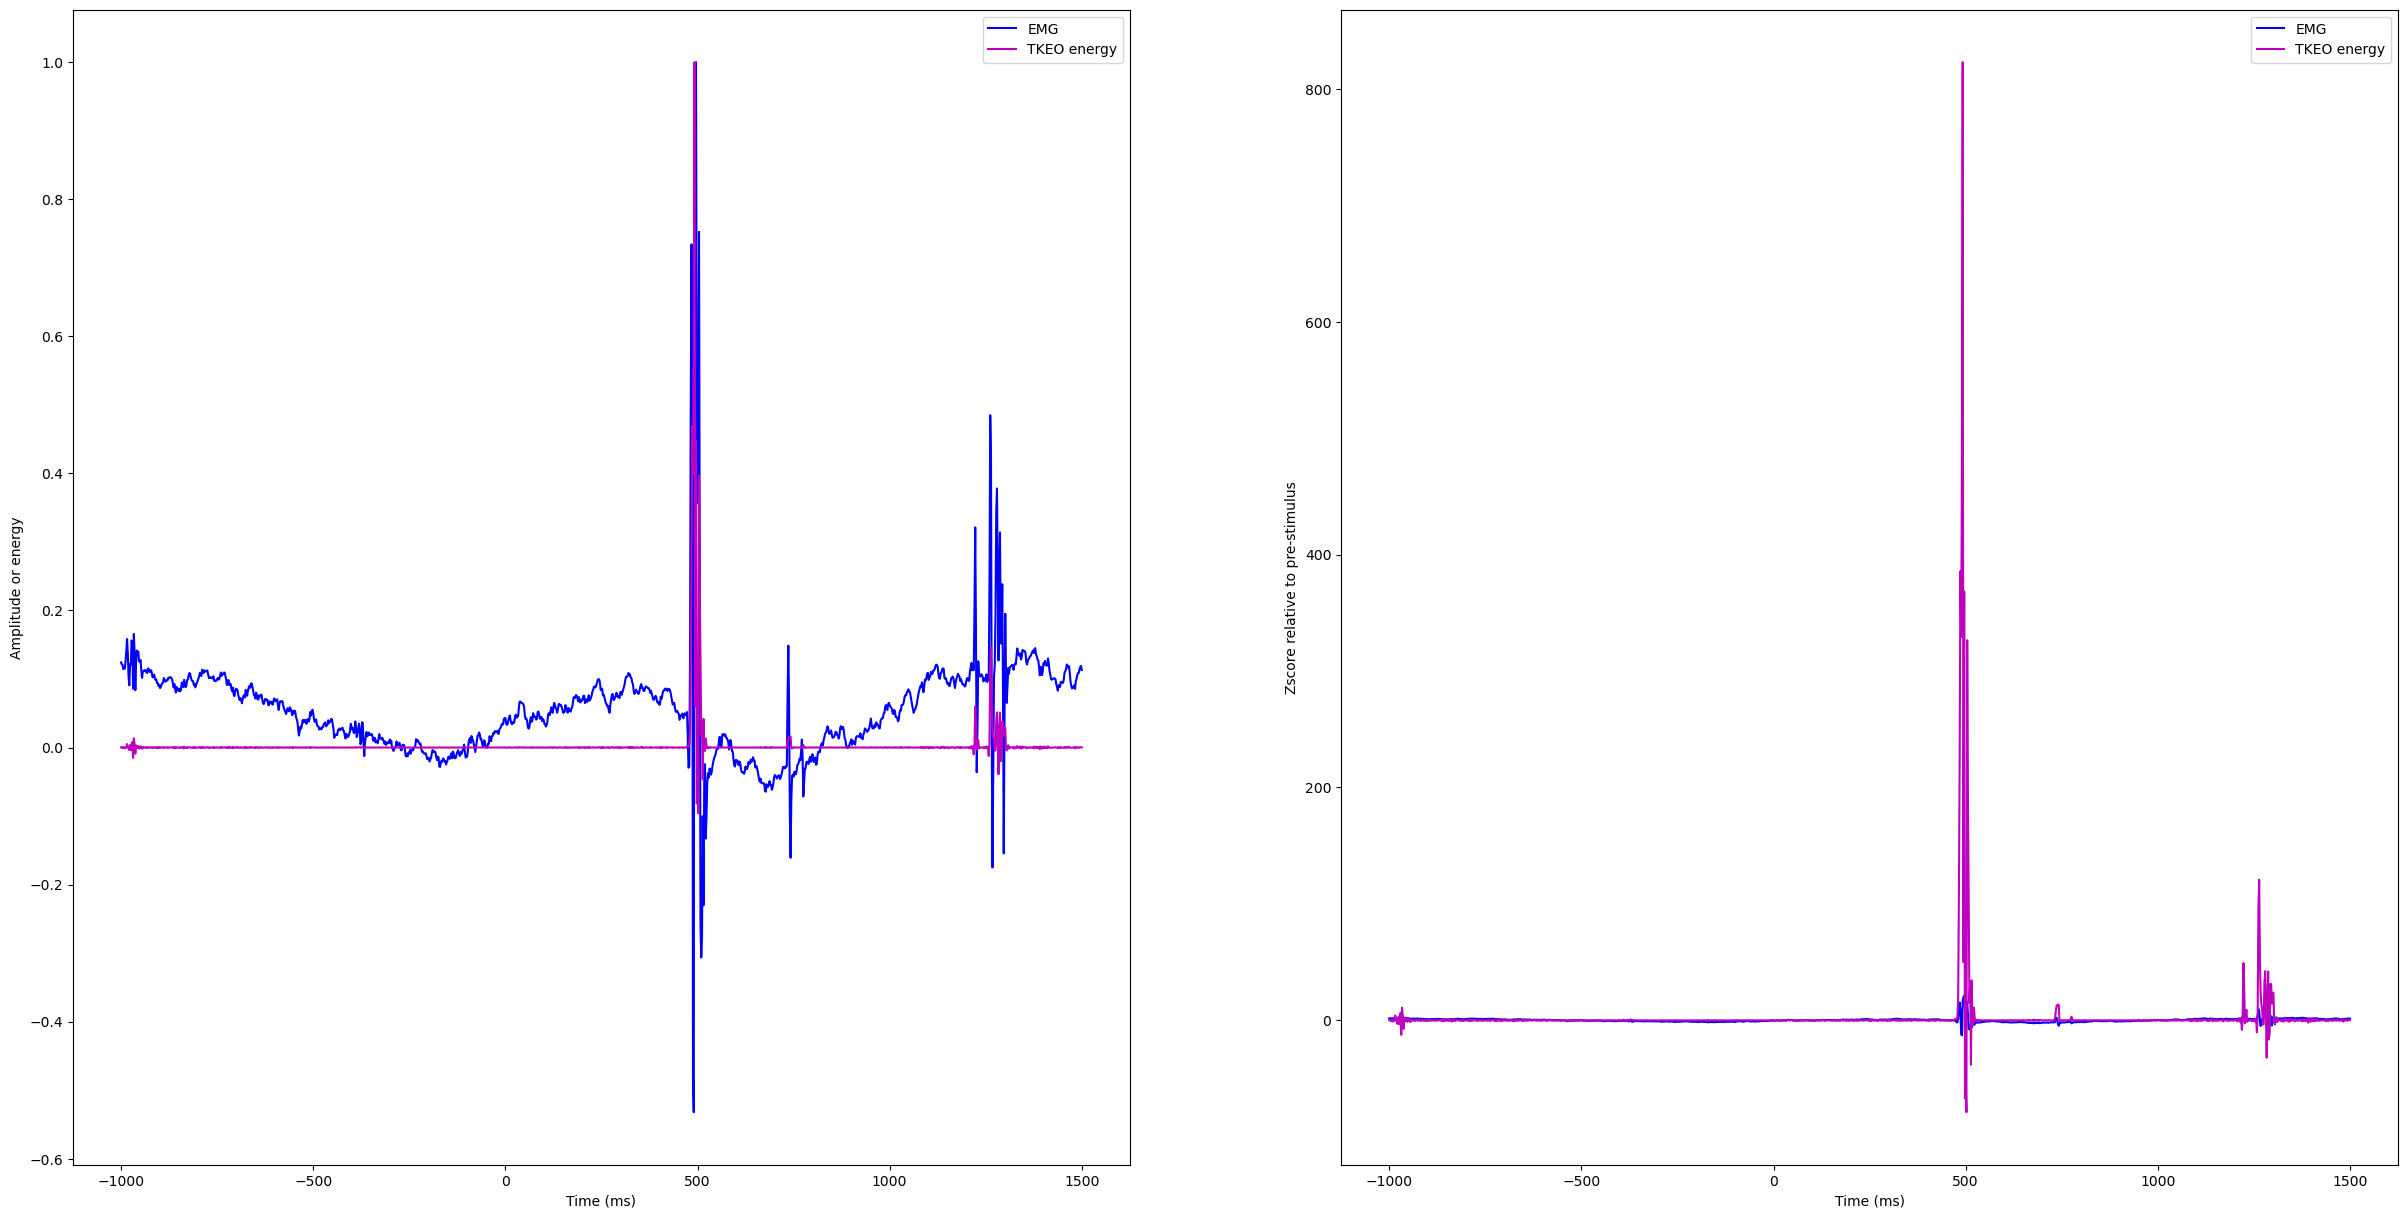

In [103]:
# initialize filtered signal
emg_filtered = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1,len(emg_filtered)-1):
    emg_filtered[i] = emg[i]**2 - emg[i-1]*emg[i+1]

# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[1:-1]**2 - emg[0:-2]*emg[2:]

## convert both signals to zscore
# find timepoint zero
time0 = np.argmin(emgtime**2)

# convert original EMG to z-score from time-zero
emgZ = (emg-np.mean(emg[0:time0])) / np.std(emg[0:time0])

# same for filtered EMG energy
emgZf = (emg_filtered-np.mean(emg_filtered[0:time0])) / np.std(emg_filtered[0:time0])

plt.figure(figsize = (30, 15))
# plot "raw" (normalized to max.1)
plt.subplot(121)
plt.plot(emgtime,emg/np.max(emg),'b',label='EMG')
plt.plot(emgtime,emg_filtered/np.max(emg_filtered),'m',label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude or energy')
plt.legend()

plt.subplot(122)
# plot zscored
plt.plot(emgtime,emgZ,'b',label='EMG')
plt.plot(emgtime,emgZf,'m',label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()


---
VIDEO: Median filter to remove spike noise
---


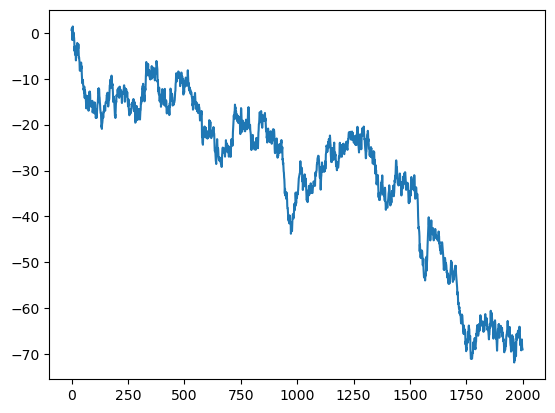

In [194]:
# create signal
n = 2000

np_arr = np.random.randn(n)
signal = np.cumsum(np_arr) # Brownian Noise
plt.plot(signal)
plt.show()

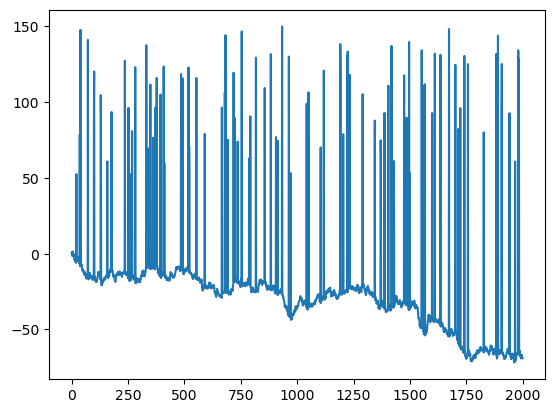

In [195]:
# proportion of time points to replace with noise
propnoise = .05

# find noise points
noisepnts = np.random.permutation(n)
noisepnts = noisepnts[0:int(n * propnoise)] # indices to be replaced
signal[noisepnts] = 50 + np.random.rand(len(noisepnts)) * 100

plt.plot(signal)
plt.show()

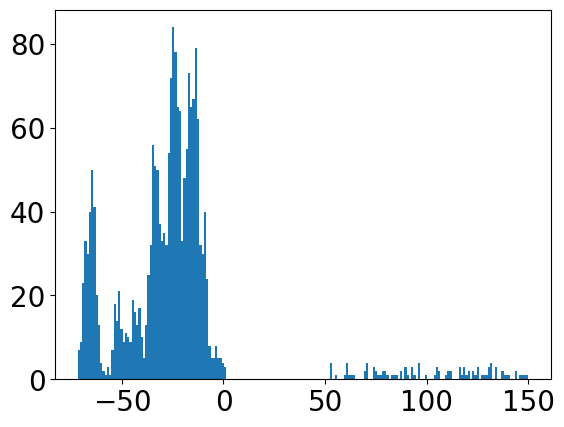

In [196]:
# use hist to pick threshold
# most of them (<100) are the signal but >100 are
plt.figure()
plt.hist(signal, 200) # bins = 100 number of bars

plt.tick_params(axis = "x", labelsize = 20)
plt.tick_params(axis = "y", labelsize = 20)
plt.show()

In [197]:
# visual-picked threshold
threshold = 0

# find data values above the threshold
suprathresh = np.where(signal > threshold)[0]  # total 43 data points
print(suprathresh)

[   0    1    5    8   21   36   39   72   99  100  129  130  158  177
  236  252  259  268  282  331  337  349  361  371  377  394  408  411
  485  492  518  521  522  553  590  666  679  680  682  685  692  718
  723  736  754  787  792  817  856  883  906  914  933  963  971 1042
 1049 1050 1051 1104 1118 1191 1192 1204 1222 1224 1231 1233 1290 1344
 1370 1371 1387 1404 1418 1419 1429 1474 1485 1496 1499 1552 1556 1563
 1566 1598 1610 1635 1673 1701 1715 1718 1723 1741 1757 1827 1883 1890
 1906 1907 1941 1966 1980 1983]


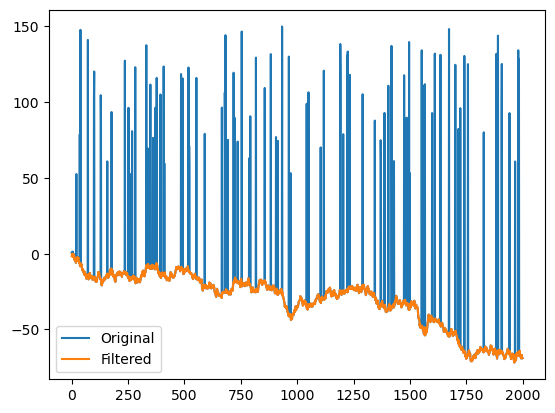

In [202]:
# initialize filtered signal
filtsig = copy.deepcopy(signal)

# loop through suprathreshold points and set to median of k
k = 20  # actual window is k*2+1
for ti in range(len(suprathresh)):

    # lower and upper bounds
    lowbnd = np.max((0, suprathresh[ti] - k))
    uppbnd = np.min((suprathresh[ti] + k + 1, n + 1))

    # compute median of surrounding points
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])

# plot
plt.figure()
plt.plot(range(0, n), signal, label = "Original")
plt.plot(range(n), filtsig, label = "Filtered")
plt.legend()
plt.show()



---
# VIDEO: Remove linear trend
---


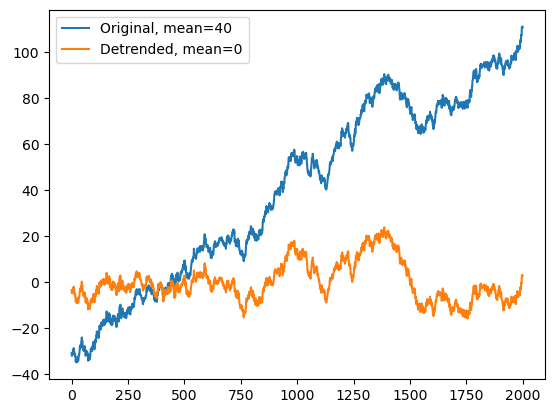

In [206]:
# create signal with linear trend imposed
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30,30,n)

# linear detrending
detsignal = scipy.signal.detrend(signal)

# get means
omean = np.mean(signal) # original mean
dmean = np.mean(detsignal) # detrended mean

# plot signal and detrended signal
plt.plot(range(0,n),signal,label='Original, mean=%d' %omean)
plt.plot(range(0,n),detsignal,label='Detrended, mean=%d' %dmean)

plt.legend()
plt.show()


---
# VIDEO: Remove nonlinear trend with polynomials
---


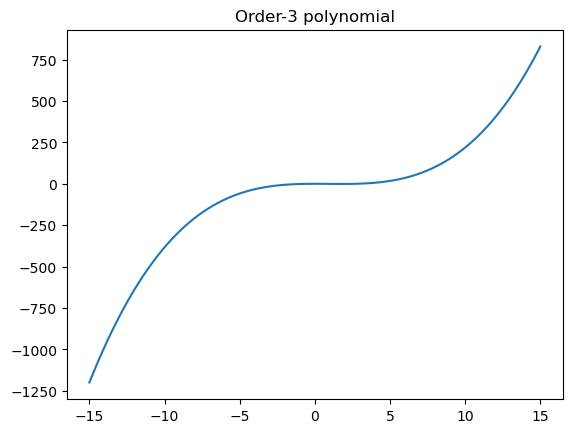

In [230]:
## polynomial intuition

order = 3
x = np.linspace(-15,15,100)

y = np.zeros(len(x))

for i in range(order+1):
    y = y + np.random.randn(1)*x**i

plt.plot(x,y)
plt.title('Order-%d polynomial' %order)
plt.show()


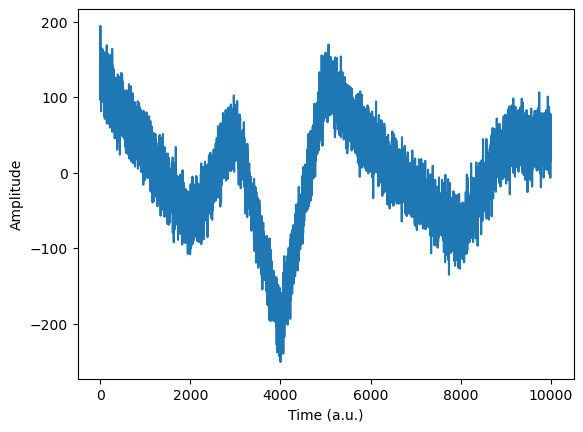

In [227]:
## generate signal with slow polynomial artifact

n = 10000
t = range(n)
k = 10  # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(0, k, n), np.arange(0, k), 100 * np.random.randn(k))
signal = slowdrift + 20 * np.random.randn(n)

# plot
plt.plot(t, signal)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

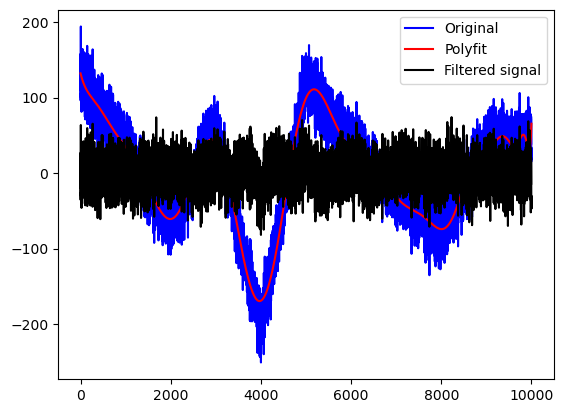

In [242]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
p = np.polyfit(t, signal, 37) # return polynomial coefficients

# predicted data is evaluation of polynomial
yHat = np.polyval(p, t)

# compute residual (the cleaned signal)
residual = signal - yHat

# now plot the fit (the function that will be removed)
plt.plot(t, signal, 'b', label = 'Original')
plt.plot(t, yHat, 'r', label = 'Polyfit')
plt.plot(t, residual, 'k', label = 'Filtered signal')

plt.legend()
plt.show()

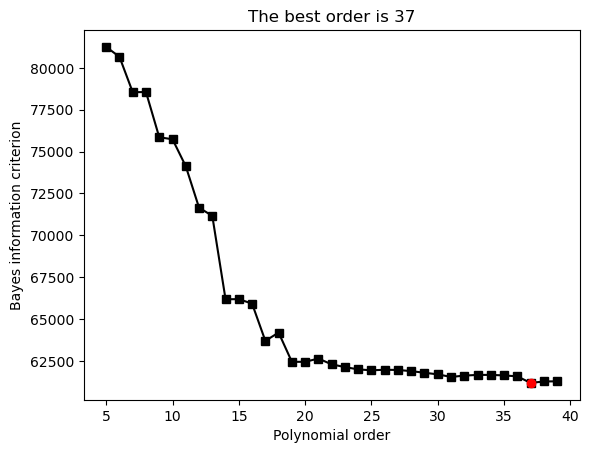

In [243]:
import warnings
warnings.filterwarnings("ignore")
## Bayes information criterion to find optimal order

# possible orders
orders = range(5,40)

# sum of squared errors (sse is reserved!)
sse1 = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):
    
    # compute polynomial (fitting time series)
    yHat = np.polyval(np.polyfit(t,signal,orders[ri]),t)
    
    # compute fit of model to data (sum of squared errors)
    sse1[ri] = np.sum( (yHat-signal)**2 )/n


# Bayes information criterion
bic = n*np.log(sse1) + orders*np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
plt.plot(orders,bic,'ks-')
plt.plot(orders[idx],bestP,'ro')
plt.title(f"The best order is {idx + orders[0]}")
plt.xlabel('Polynomial order')
plt.ylabel('Bayes information criterion')
plt.show()

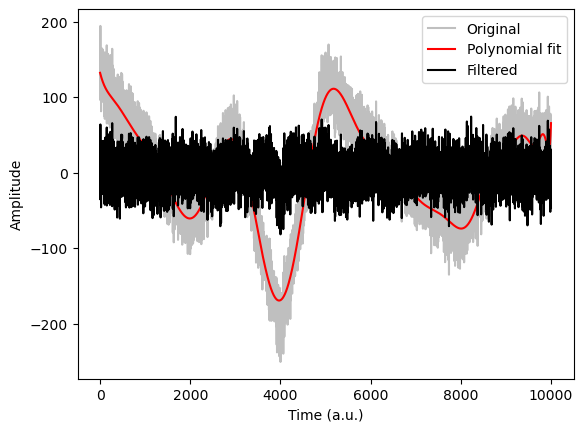

In [248]:
## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = np.polyfit(t,signal,orders[idx])

# estimated data based on the coefficients
yHat = np.polyval(polycoefs,t)

# filtered signal is residual
filtsig = signal - yHat


## plotting
import matplotlib.colors as mcolors
plt.plot(t,signal, '0.75',label='Original')
plt.plot(t,yHat,'r',label='Polynomial fit')
plt.plot(t,filtsig,'k',label='Filtered')

plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


---
# VIDEO: Averaging multiple repetitions (time-synchronous averaging)
---


In [ ]:
## simulate data

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp( -np.linspace(-2,2,k+1)**2 ))
event = event/np.max(event) # normalize to max=1

# event onset times
Nevents = 30
onsettimes = np.random.permutation(10000-k)
onsettimes = onsettimes[0:Nevents]

# put event into data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei]+k] = event

# add noise
data = data + .5*np.random.randn(len(data))

# plot data
plt.subplot(211)
plt.plot(data)

# plot one event
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]:onsettimes[3]+k])
plt.plot(range(k), event)
plt.show()

In [ ]:
## extract all events into a matrix

datamatrix = np.zeros((Nevents,k))

for ei in range(Nevents):
    datamatrix[ei,:] = data[onsettimes[ei]:onsettimes[ei]+k]

plt.imshow(datamatrix)
plt.xlabel('Time')
plt.ylabel('Event number')
plt.title('All events')
plt.show()

plt.plot(range(0,k),np.mean(datamatrix,axis=0),label='Averaged')
plt.plot(range(0,k),event,label='Ground-truth')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Average events')
plt.show()


---
# VIDEO: Remove artifact via least-squares template-matching
---


In [ ]:
# load dataset
matdat = sio.loadmat('templateProjection.mat')
EEGdat = matdat['EEGdat']
eyedat = matdat['eyedat']
timevec = matdat['timevec'][0]
MN = np.shape(EEGdat) # matrix sizes

# initialize residual data
resdat = np.zeros(np.shape(EEGdat))


# loop over trials
for triali in range(MN[1]):
    
    # build the least-squares model as intercept and EOG from this trial
    X = np.column_stack((np.ones(MN[0]),eyedat[:,triali]))
    
    # compute regression coefficients for EEG channel
    b = np.linalg.solve(X.T@X,X.T@EEGdat[:,triali])
    
    # predicted data
    yHat = X@b
    
    # new data are the residuals after projecting out the best EKG fit
    resdat[:,triali] = EEGdat[:,triali] - yHat

In [ ]:
### plotting

# trial averages
plt.plot(timevec,np.mean(eyedat,axis=1),label='EOG')
plt.plot(timevec,np.mean(EEGdat,axis=1),label='EEG')
plt.plot(timevec,np.mean(resdat,1),label='Residual')

plt.xlabel('Time (ms)')
plt.legend()
plt.show()

In [ ]:
# show all trials in a map
clim = [-1,1]*20

plt.subplot(131)
plt.imshow(eyedat.T)
plt.title('EOG')


plt.subplot(132)
plt.imshow(EEGdat.T)
plt.title('EOG')


plt.subplot(133)
plt.imshow(resdat.T)
plt.title('Residual')

plt.tight_layout()
plt.show()